# How to seperate graph and session

我们在使用tensorflow的时候，需要先将整个计算流程用一个graph来表示，之后用session来进行实际计算。所以大部分的tensorflow的代码，graph和session都是写在一个函数里面的。但是为了将整个程序模块化，我们可能需要将整个graph拆分成很多个不同的模块，同时和session分离。

比如我们可以用类来表示一个模型，其中一个方法专门用来构建graph，另外一个方法用来执行一个session。
首先我们来看一下一个错误的class 代码：

```python
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import tensorflow as tf

import numpy as np


class DataAgent(object):
    """docstring for DataAgent"""
    def __init__(self):
        super(DataAgent, self).__init__()
        self.getData()
    def getData(self):
        self.X = np.arange(0,100,0.001)

        self.y = 2*self.X*self.X + self.X + 0.5

        self.X = np.hstack((self.X.reshape(-1,1),np.reshape(self.X*self.X,[-1,1])))
        

    def getBatch(self):
        indices = np.random.choice(self.X.shape[0],20)

        x =  self.X[indices,:]
        
        y = self.y[indices].reshape(-1,1)

        return x,y
        

class TFGraph(object):
    def __init__(self,dataAgent):
        self.dataAgent = dataAgent
        self.build_graph()

    def add_placeholder(self):
        self.batch = tf.placeholder(tf.float32,shape = [20,2])

        self.label = tf.placeholder(tf.float32,shape = [20,1])

    def build_graph(self):
        
        with graph.as_default():
            self.add_placeholder()

            self.W = tf.Variable(tf.random_normal([2,1],mean = 0.0,stddev = 1.0))

            self.b = tf.Variable(tf.zeros(1))

            y_pre = tf.matmul(self.batch,self.W) + self.b

            self.loss = 0.5*tf.reduce_mean(tf.square(y_pre-self.label))

            optimizer = tf.train.AdamOptimizer(0.075)

            self.train_op = optimizer.minimize(self.loss)

        

    def train(self):
        
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            sess.run(init)
            for i in range(10000):

                batch,labels = self.dataAgent.getBatch()

                loss,_=sess.run([self.loss,self.train_op],feed_dict = {self.batch:batch,self.label:labels})
                if i % 1000 ==0:
                    print("step:%s, loss:%s"%(i,loss))

             W,b = sess.run([self.W,self.b])

             print(W)
             print(b)


if __name__ == "__main__":
    da = DataAgent()
    graph = TFGraph(da)
    graph.train()

```

上面的代码会报错，因为在train()这个函数里面，从init开始，包括session部分实际上是在另外一个graph中，而并不是之前在build_graph()中所构建的graph。所以我们需要保存在build_graph()中所构建的graph，并且在train()中使用。

In [6]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import tensorflow as tf

import numpy as np


class DataAgent(object):
    """docstring for DataAgent"""
    def __init__(self):
        super(DataAgent, self).__init__()
        self.getData()
    def getData(self):
        self.X = np.arange(0,100,0.001)

        self.y = 2*self.X*self.X + self.X + 0.5

        self.X = np.hstack((self.X.reshape(-1,1),np.reshape(self.X*self.X,[-1,1])))
        

    def getBatch(self):
        indices = np.random.choice(self.X.shape[0],20)

        x =  self.X[indices,:]
        
        y = self.y[indices].reshape(-1,1)

        return x,y
        

class TFGraph(object):
    def __init__(self,dataAgent):
        self.dataAgent = dataAgent
        self.graph = self.build_graph()

    def add_placeholder(self):
        self.batch = tf.placeholder(tf.float32,shape = [20,2])

        self.label = tf.placeholder(tf.float32,shape = [20,1])

    def build_graph(self):
        graph = tf.Graph()
        with graph.as_default():
            self.add_placeholder()

            self.W = tf.Variable(tf.random_normal([2,1],mean = 0.0,stddev = 1.0))

            self.b = tf.Variable(tf.zeros(1))

            y_pre = tf.matmul(self.batch,self.W) + self.b

            self.loss = 0.5*tf.reduce_mean(tf.square(y_pre-self.label))

            optimizer = tf.train.AdamOptimizer(0.075)

            self.train_op = optimizer.minimize(self.loss)

        return graph

    def train(self):
        with self.graph.as_default():
            init = tf.global_variables_initializer()

            with tf.Session() as sess:
                sess.run(init)
                for i in range(20000):

                    batch,labels = self.dataAgent.getBatch()

                    loss,_=sess.run([self.loss,self.train_op],feed_dict = {self.batch:batch,self.label:labels})
                    if i % 1000 ==0:
                        print("step:%s, loss:%s"%(i,loss))

                W,b = sess.run([self.W,self.b])

                print(W)
                print(b)




In [7]:
da = DataAgent()
graph = TFGraph(da)
graph.train()

step:0, loss:1.48049e+07
step:1000, loss:117.261
step:2000, loss:7.27961
step:3000, loss:0.635055
step:4000, loss:0.394717
step:5000, loss:0.399164
step:6000, loss:52.0795
step:7000, loss:18.4076
step:8000, loss:2.94556
step:9000, loss:0.000826972
step:10000, loss:0.00168912
step:11000, loss:0.000405265
step:12000, loss:0.000216781
step:13000, loss:5.57338e-05
step:14000, loss:395.849
step:15000, loss:0.00337271
step:16000, loss:0.0139757
step:17000, loss:0.0774716
step:18000, loss:0.000732884
step:19000, loss:0.45353
[[ 1.04096508]
 [ 1.99983835]]
[ 0.60853249]


In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
x = np.arange(0,100,0.001)
y = 2*x*x + x + 0.5

y_pred = 1.99983835 * x*x + 1.04096508*x + 0.60853249

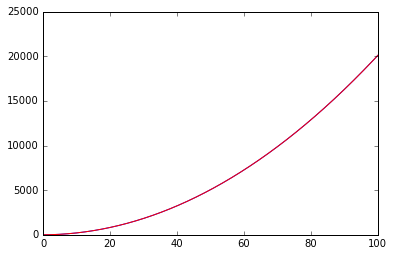

In [14]:
plt.plot(x,y,'b',x,y_pred,'r')